# Curved Lane Lines Detection

### The lane detection system was written in Python using the OpenCV library. Here's the current image processing pipeline:

    Distortion Correction

    Perspective Warp

    Sobel Filtering

    Histogram Peak Detection

    Sliding Window Search

    Curve Fitting

    Overlay Detected Lane

    Apply to Video

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle

## Important Functions 

In [5]:
def undistort_img():
    # Prepare object points 0,0,0 ... 8,5,0
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('camera_cal/*.jpg')

    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(obj_pts)
            imgpoints.append(corners)
    # Test undistortion on img
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open('camera_cal/cal_pickle.p', 'wb') )
undistort_img()

### Undistort Image

In [6]:
def undistort(img, cal_dir='camera_cal/cal_pickle.p'):
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = undistort(img)

### Result of Calibration

Text(0.5,1,'Undistorted Image')

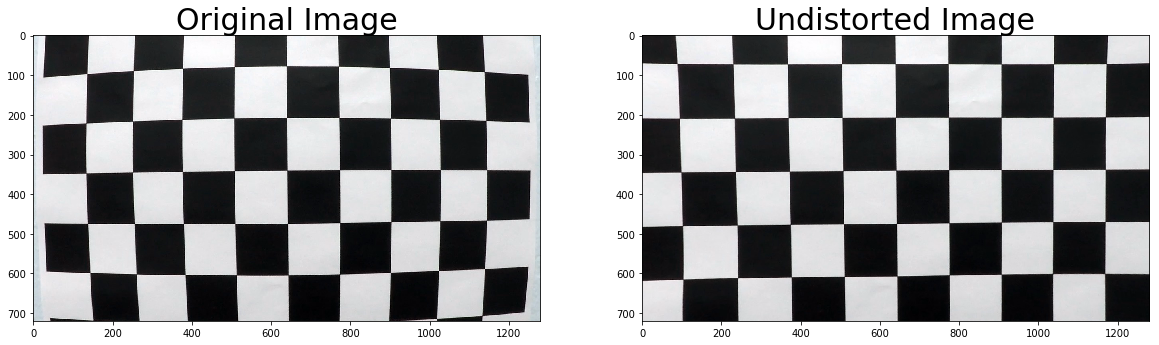

In [37]:
img = cv2.imread('camera_cal/calibration1.jpg')
dst = undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Result of Undistorted and Distorted images

Text(0.5,1,'Undistorted Image')

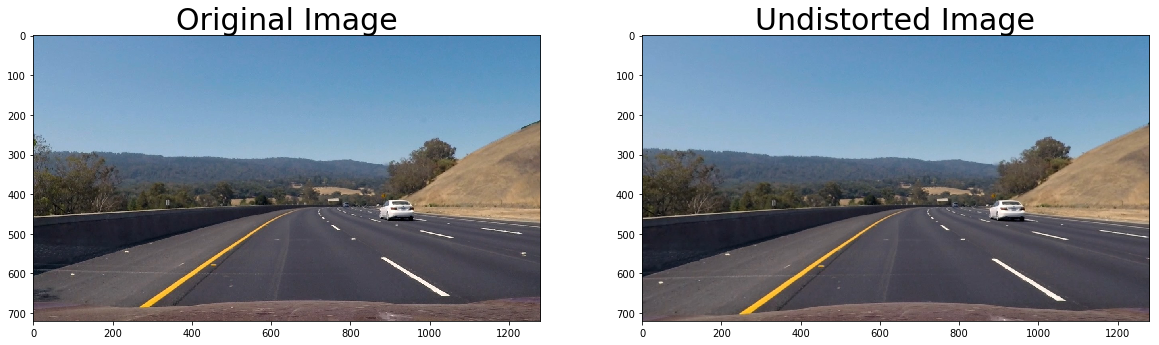

In [38]:
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)



### Color Filter

In [8]:
def colorFilter(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    lowerYellow = np.array([18,94,140])
    upperYellow = np.array([48,255,255])
    lowerWhite = np.array([0, 0, 200])
    upperWhite = np.array([255, 255, 255])
    maskedWhite= cv2.inRange(hsv,lowerWhite,upperWhite)
    maskedYellow = cv2.inRange(hsv, lowerYellow, upperYellow)
    combinedImage = cv2.bitwise_or(maskedWhite,maskedYellow)
    return combinedImage


### Threshold

In [9]:
def thresholding(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5,5))
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 0)
    imgCanny = cv2.Canny(imgBlur, 50, 100)
    #imgClose = cv2.morphologyEx(imgCanny, cv2.MORPH_CLOSE, np.ones((10,10)))
    imgDial = cv2.dilate(imgCanny,kernel,iterations=1)
    imgErode = cv2.erode(imgDial,kernel,iterations=1)

    imgColor = colorFilter(img)
    combinedImage = cv2.bitwise_or(imgColor, imgErode)

    return combinedImage,imgCanny,imgColor

### Draw Points

In [10]:
def drawPoints(img,src):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    #src = np.float32([(0.43, 0.65), (0.58, 0.65), (0.1, 1), (1, 1)])
    src = src * img_size
    for x in range( 0,4):
        cv2.circle(img,(int(src[x][0]),int(src[x][1])),15,(0,0,255),cv2.FILLED)
    return img

### Prespective Warp 

In [11]:
def perspective_warp(img,
                     dst_size=(1280, 720),
                     src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)

    return warped

### HLS & Sobel Function

In [12]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(15, 255)):
    img = undistort(img)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    h_channel = hls[:, :, 0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

### Invers Prespective Warp

In [13]:
def inv_perspective_warp(img,
                     dst_size=(1280,720),
                     src=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
                     dst=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

### Histogram

In [14]:
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

In [15]:
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = pipeline(img)
dst = perspective_warp(dst, dst_size=(1280,720))

### Sliding Window 

In [16]:
left_a, left_b, left_c = [], [], []
right_a, right_b, right_c = [], [], []

def sliding_window(img, nwindows=15, margin=50, minpix=1, draw_windows=True):
    global left_a, left_b, left_c, right_a, right_b, right_c
    left_fit_ = np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img)) * 255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(img.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                          (100, 255, 255), 1)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                          (100, 255, 255), 1)
            # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    #        if len(good_right_inds) > minpix:
    #            rightx_current = np.int(np.mean([leftx_current +900, np.mean(nonzerox[good_right_inds])]))
    #        elif len(good_left_inds) > minpix:
    #            rightx_current = np.int(np.mean([np.mean(nonzerox[good_left_inds]) +900, rightx_current]))
    #        if len(good_left_inds) > minpix:
    #            leftx_current = np.int(np.mean([rightx_current -900, np.mean(nonzerox[good_left_inds])]))
    #        elif len(good_right_inds) > minpix:
    #            leftx_current = np.int(np.mean([np.mean(nonzerox[good_right_inds]) -900, leftx_current]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if leftx.size and rightx.size:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        left_a.append(left_fit[0])
        left_b.append(left_fit[1])
        left_c.append(left_fit[2])

        right_a.append(right_fit[0])
        right_b.append(right_fit[1])
        right_c.append(right_fit[2])

        left_fit_[0] = np.mean(left_a[-10:])
        left_fit_[1] = np.mean(left_b[-10:])
        left_fit_[2] = np.mean(left_c[-10:])

        right_fit_[0] = np.mean(right_a[-10:])
        right_fit_[1] = np.mean(right_b[-10:])
        right_fit_[2] = np.mean(right_c[-10:])

        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])

        left_fitx = left_fit_[0] * ploty ** 2 + left_fit_[1] * ploty + left_fit_[2]
        right_fitx = right_fit_[0] * ploty ** 2 + right_fit_[1] * ploty + right_fit_[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]

        return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty
    else:
        return img,(0,0),(0,0),0

### Calculate Curve

In [17]:
def get_curve(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 1 / img.shape[0]  # meters per pixel in y dimension
    xm_per_pix = 0.1 / img.shape[0]  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    car_pos = img.shape[1] / 2
    l_fit_x_int = left_fit_cr[0] * img.shape[0] ** 2 + left_fit_cr[1] * img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0] * img.shape[0] ** 2 + right_fit_cr[1] * img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) / 2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters

    return (l_fit_x_int, r_fit_x_int, center)

### Draw lanes

In [18]:
def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (100,100,255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 0.5, inv_perspective, 0.7, 0)
    return inv_perspective

### Stack Images to Show all Processed Images

In [21]:
def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

### Printing out Stacked Images using CV2

In [34]:
imgWarpPoints = img.copy()
imgFinal = img.copy()
imgCanny = img.copy()

src = np.float32([(0.38, 0.67), (0.6, 0.67), (0.25, 0.85), (0.82, 0.85)])

dst = undistort(img)
imgThres,imgCanny,imgColor = thresholding(dst)
imgWarp = perspective_warp(imgThres, dst_size=(img.shape[1], img.shape[0]))
imgWarpPoints = drawPoints(imgWarpPoints,src)
imgSliding, curves, lanes, ploty = sliding_window(imgWarp, draw_windows=True)
curverad = get_curve(imgFinal, curves[0], curves[1])
lane_curve = np.mean([curverad[0], curverad[1]])
imgFinal = draw_lanes(img, curves[0], curves[1])

stack_images = stackImages(0.4, ([img,dst,imgWarpPoints],
                  [imgColor, imgCanny, imgThres],
                  [imgWarp,imgSliding,imgFinal]
                                         ))
# cv2.imshow("Pipeline Images",stack_images)

### Pipeline 

In [21]:
def video_pipeline(img):
    
    img_ = pipeline(img)
    img_ = perspective_warp(img_)
    out_img, curves, lanes, ploty = sliding_window(img_, draw_windows=False)
    curverad =get_curve(img, curves[0], curves[1])
    lane_curve = np.mean([curverad[0], curverad[1]])
    img = draw_lanes(img, curves[0], curves[1])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (570, 620), font, fontSize, fontColor, 2)
    cv2.putText(img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (570, 650), font, fontSize, fontColor, 2)
    return img

(2, 720)
(783.16790227584272, 5016.2632728161116, -0.031384938715916348)


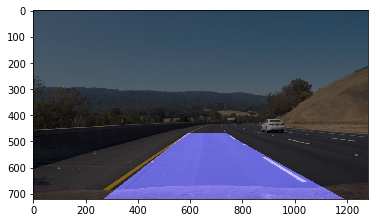

In [37]:
#%matplotlib gtk
out_img, curves, lanes, ploty = sliding_window(dst)
#plt.imshow(out_img)
#plt.plot(curves[0], ploty, color='yellow', linewidth=1)
#plt.plot(curves[1], ploty, color='yellow', linewidth=1)
print(np.asarray(curves).shape)
curverad=get_curve(img, curves[0],curves[1])
print(curverad)
img_ = draw_lanes(img, curves[0], curves[1])
plt.imshow(img_, cmap='hsv')

In [40]:
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(video_pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 24%|██▍       | 303/1261 [01:11<04:19,  3.70it/s]


 48%|████▊     | 605/1261 [02:28<02:54,  3.76it/s]


 72%|███████▏  | 907/1261 [03:43<01:26,  4.10it/s]


 96%|█████████▌| 1205/1261 [05:01<00:14,  3.98it/s]


100%|█████████▉| 1260/1261 [05:15<00:00,  3.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 34s, sys: 49.7 s, total: 3min 23s
Wall time: 5min 17s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

In [46]:
video_output2 = 'challenge_video.mp4_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')
processed_video = video_input2.fl_image(video_pipeline)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video.mp4_output.mp4
[MoviePy] Writing video challenge_video.mp4_output.mp4



100%|██████████| 485/485 [01:41<00:00,  4.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video.mp4_output.mp4 

CPU times: user 52 s, sys: 10.1 s, total: 1min 2s
Wall time: 1min 43s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))